# Tree depth experiment

I chose a max tree depth of 3 for our XGBoost model. Here we train and test on various tree depths to show how tree depth impacts performance, and we show that a max depth of 3 was a sensible choice.

Note that the plots shown in this notebook are not the correct results (the correct results are saved in the tree_depth_experiment/ folder). This is because I subsetted the data (by only taking 100 features) when developing this notebook, in order to make it run faster while developing. I then ran this notebook as a .py file (as it takes a while to run) to get the results that are shown in the tree_depth_experiment/ folder.

### Load data

In [ ]:
# first, load data (only the first fold)
import pandas as pd
processed_data = pd.read_csv('data/training_testing_maxgap_50_newdata_processed_m_vals.csv')
processed_data

import numpy as np
data = np.array(processed_data.iloc[:, 3:])
data = np.transpose(data)

diagnoses = pd.read_csv('data/training_testing_diagnoses_maxgap_50_newdata.csv', sep = ',')
diagnoses = diagnoses.iloc[2:, ]
pooled_labels = np.array([4 if d == 5 else d for d in diagnoses['overallpath']])

# get indices of test data
import pickle
test_indices_list = pickle.load(open('figs_xgboost/test_indices_list.json', 'rb'))

In [86]:
# get data for the ith fold
def get_data(i):
    train_indices = np.array(list(set(range(len(pooled_labels))) - set(test_indices_list[i]))) # all indices except test indices
    train_data = data[train_indices, :]
    print(train_data.shape)
    train_y_true = pooled_labels[train_indices]
    print(len(train_y_true))

    test_indices = test_indices_list[i] 
    test_data = data[test_indices, :]
    test_y_true = pooled_labels[test_indices]
    print(test_data.shape)
    print(len(test_y_true))
    
    return(train_data, train_y_true, test_data, test_y_true)

train_data, train_y_true, test_data, test_y_true = get_data(0)

(909, 158670)
909
(319, 158670)
319


In [89]:
# subset data for developing code: 
train_data = train_data[:,0:100]
test_data = test_data[:,0:100]

### Train and test XGBoost models with different max_depths

In [90]:


import xgboost as xgb
from sklearn.metrics import matthews_corrcoef, accuracy_score, f1_score, confusion_matrix, precision_score, recall_score

def train_and_test(train_data, train_y_true, test_data, test_y_true):
    scores = pd.DataFrame()
    conf_mats = []
    for depth in range(2, 20): 
        model = xgb.XGBClassifier(max_depth=depth, subsample = 0.5, colsample_bytree = 0.5)

        model.fit(train_data, train_y_true)

        predictions = model.predict(test_data)

        # return scores
        mcc = matthews_corrcoef(test_y_true, predictions)
        acc = accuracy_score(test_y_true, predictions)
        f1= f1_score(test_y_true, predictions, average = None)
        conf_mat = confusion_matrix(test_y_true, predictions)
        precision = precision_score(test_y_true, predictions, average = None)
        recall = recall_score(test_y_true, predictions, average = None)

        # scores over train data:
        predictions_train = model.predict(train_data)
        acc_train = accuracy_score(train_y_true, predictions_train)
        mcc_train = matthews_corrcoef(train_y_true, predictions_train)

        score = pd.DataFrame({'max_depth':depth, 'mcc':mcc, 'acc':acc,'f1': f1,'precision':precision,'recall':recall, 'acc_train': acc_train, 'mcc_train':mcc_train})
        conf_mats.append(conf_mat)
        scores = scores.append(score)
        
    return(scores, conf_mats)

scores, conf_mats = train_and_test(train_data, train_y_true, test_data, test_y_true)


In [91]:
scores

,max_depth,mcc,acc,f1,precision,recall,acc_train,mcc_train
0,2,0.827207,0.874608,0.971098,0.954545,0.988235,0.986799,0.981741
1,2,0.827207,0.874608,0.866142,0.808824,0.932203,0.986799,0.981741
2,2,0.827207,0.874608,0.731707,0.937500,0.600000,0.986799,0.981741
3,2,0.827207,0.874608,0.592593,0.800000,0.470588,0.986799,0.981741
4,2,0.827207,0.874608,0.867133,0.898551,0.837838,0.986799,0.981741
...,...,...,...,...,...,...,...,...
0,19,0.836060,0.880878,0.976744,0.965517,0.988235,1.000000,1.000000
1,19,0.836060,0.880878,0.866142,0.808824,0.932203,1.000000,1.000000
2,19,0.836060,0.880878,0.731707,0.937500,0.600000,1.000000,1.000000
3,19,0.836060,0.880878,0.642857,0.818182,0.529412,1.000000,1.000000


### Look at scores

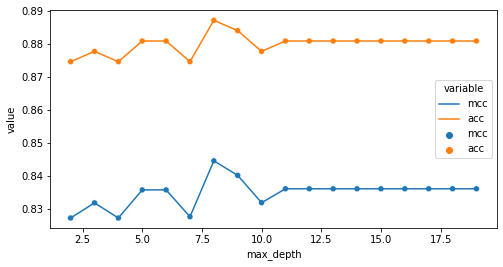

In [96]:
import seaborn as sb
import matplotlib.pyplot as plt

def plot_acc_and_mcc(scores, fold):
    to_plot = scores[['max_depth', 'mcc', 'acc']].drop_duplicates()
    to_plot = pd.melt(to_plot, 'max_depth')
    plt.figure(figsize=(8, 4))
    sp = sb.scatterplot(data=to_plot, x = 'max_depth', y = 'value', hue='variable')
    lp = sb.lineplot(data=to_plot, x = 'max_depth', y = 'value', hue='variable')

    plt.savefig('tree_depth_experiment/acc_and_mcc_scores_' + str(fold) + '.svg')
    
plot_acc_and_mcc(scores, 0)

/home/in268/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


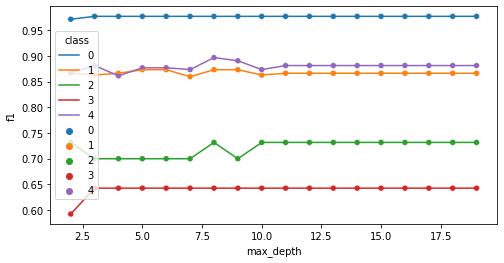

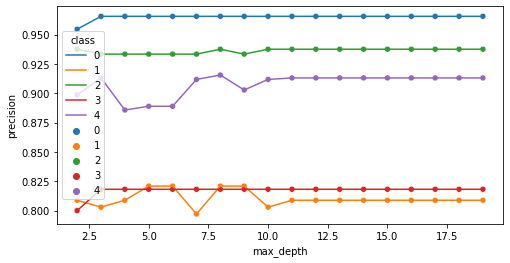

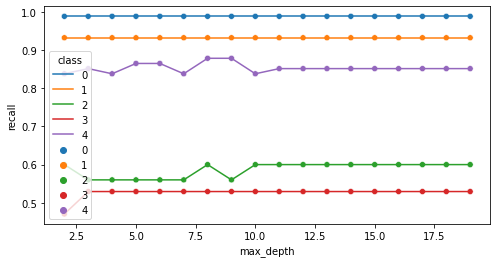

In [97]:
def plot_other_metrics(scores, fold):
    to_plot = scores[['max_depth', 'f1', 'precision', 'recall']]
    to_plot['class'] = [str(i) for i in scores.index] # the index indices the class for f1, precision and recall
    to_plot

    plt.figure(figsize=(8, 4))
    sb.scatterplot(data=to_plot, x = 'max_depth', y = 'f1', hue='class')
    sb.lineplot(data=to_plot, x = 'max_depth', y = 'f1', hue='class')
    plt.savefig('tree_depth_experiment/f1_scores_' + str(fold) + '.svg')
    plt.show()

    plt.figure(figsize=(8, 4))
    sb.scatterplot(data=to_plot, x = 'max_depth', y = 'precision', hue='class')
    sb.lineplot(data=to_plot, x = 'max_depth', y = 'precision', hue='class')
    plt.savefig('tree_depth_experiment/precision_scores_' + str(fold) + '.svg')
    plt.show()

    plt.figure(figsize=(8, 4))
    sb.scatterplot(data=to_plot, x = 'max_depth', y = 'recall', hue='class')
    sb.lineplot(data=to_plot, x = 'max_depth', y = 'recall', hue='class')
    plt.savefig('tree_depth_experiment/recall_scores_' + str(fold) + '.svg')
    plt.show()
    
plot_other_metrics(scores, 0)

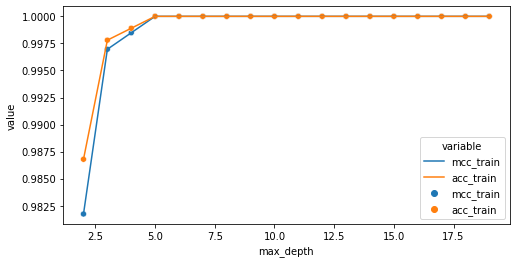

In [98]:
# now plot train scores
import seaborn as sb
import matplotlib.pyplot as plt

def plot_train_acc_and_mcc(scores, fold):
    to_plot = scores[['max_depth', 'mcc_train', 'acc_train']].drop_duplicates()
    to_plot = pd.melt(to_plot, 'max_depth')
    plt.figure(figsize=(8, 4))
    sp = sb.scatterplot(data=to_plot, x = 'max_depth', y = 'value', hue='variable')
    lp = sb.lineplot(data=to_plot, x = 'max_depth', y = 'value', hue='variable')

    plt.savefig('tree_depth_experiment/acc_and_mcc_train_scores_' + str(fold) + '.svg')
    
plot_train_acc_and_mcc(scores, 0)

### Now run for all folds

(909, 158670)
909
(319, 158670)
319


/home/in268/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


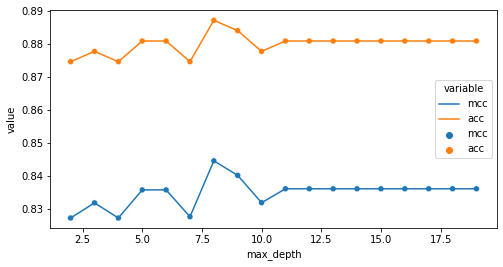

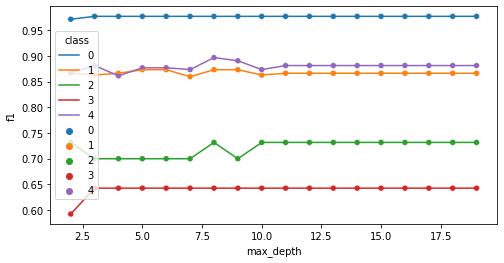

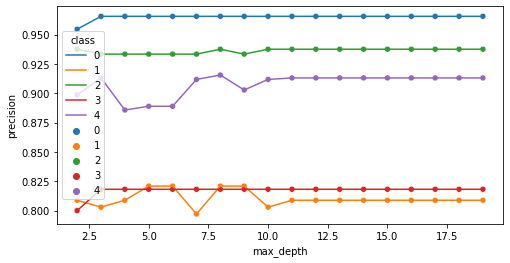

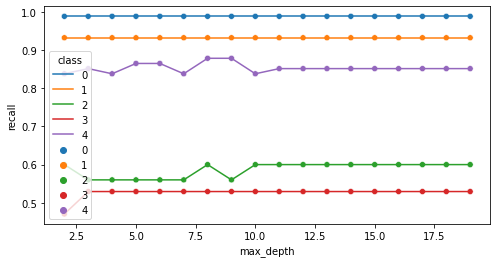

(926, 158670)
926
(302, 158670)
302


/home/in268/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


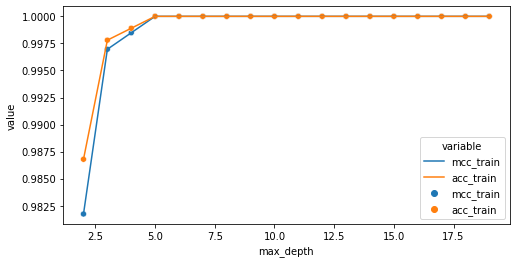

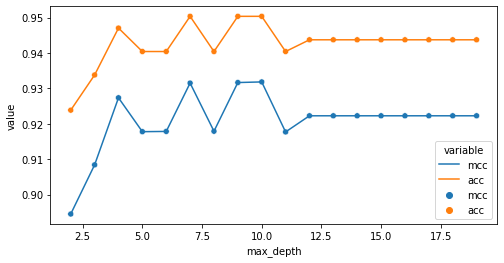

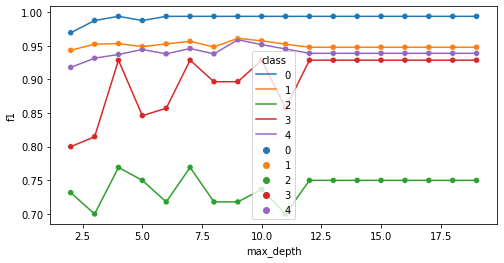

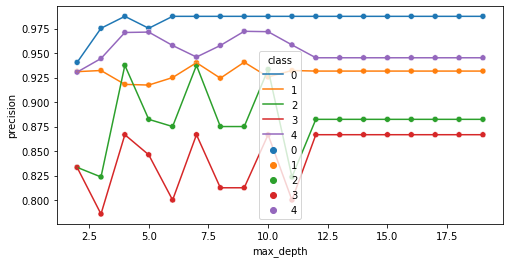

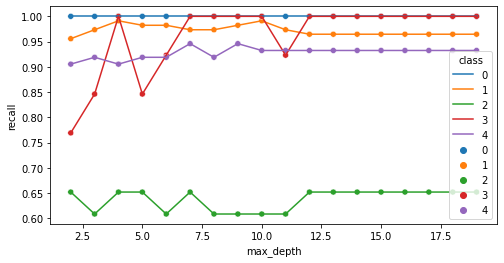

(918, 158670)
918
(310, 158670)
310


/home/in268/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


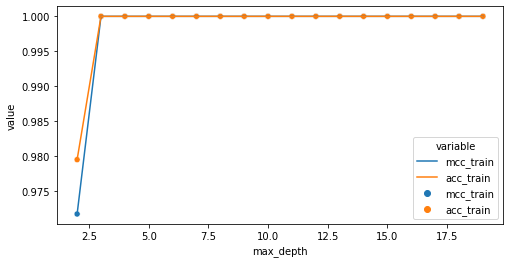

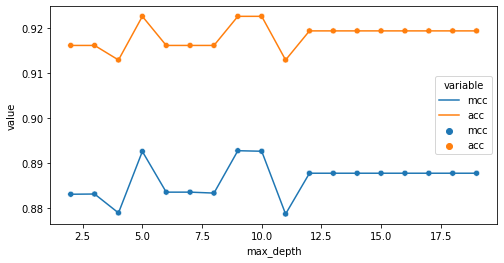

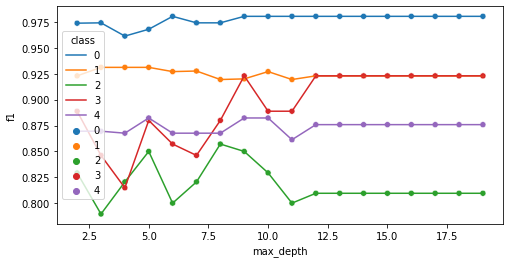

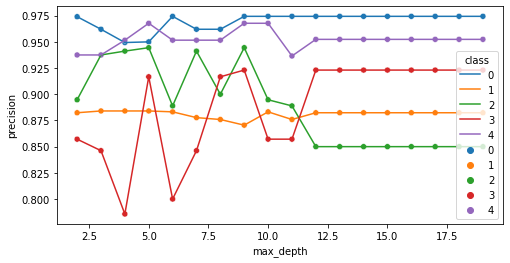

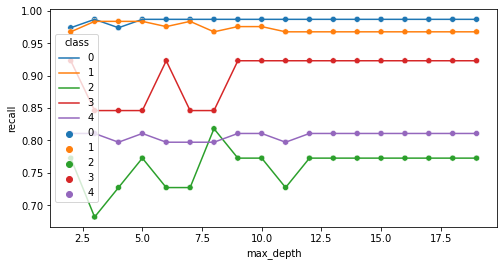

(931, 158670)
931
(297, 158670)
297


/home/in268/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


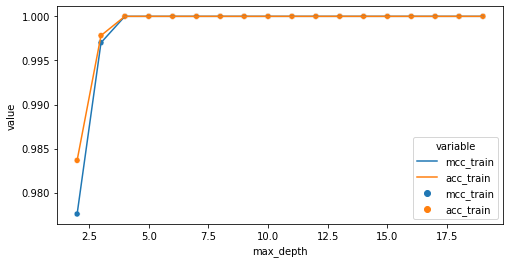

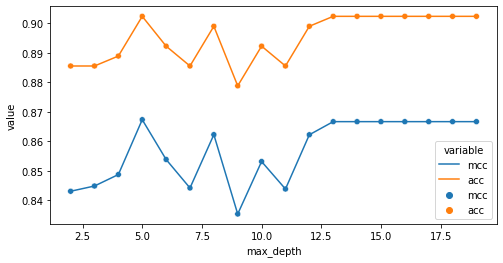

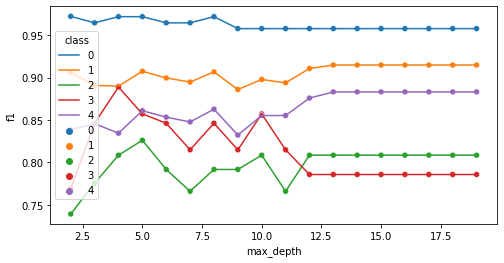

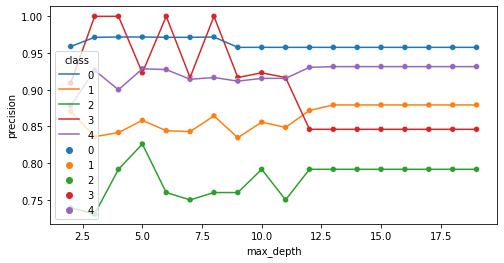

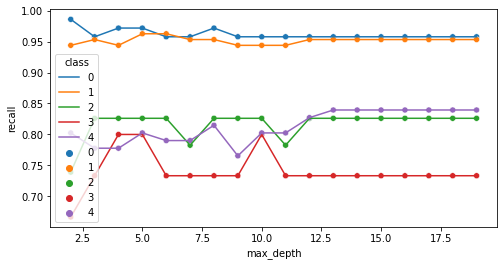

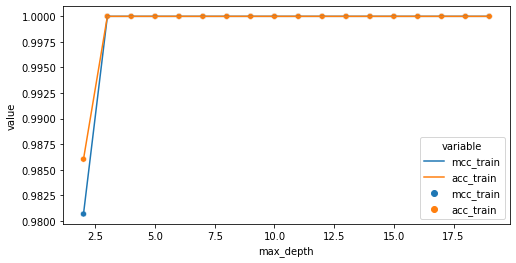

In [101]:
scores_all_folds = pd.DataFrame()

for i in range(4):
    train_data, train_y_true, test_data, test_y_true = get_data(i)

    # subset data for developing code: 
#     train_data = train_data[:,0:100]
#     test_data = test_data[:,0:100]

    scores, conf_mats = train_and_test(train_data, train_y_true, test_data, test_y_true)
    
    plot_acc_and_mcc(scores, i)
    plot_other_metrics(scores, i)
    plot_train_acc_and_mcc(scores, i)
    
    scores['fold'] = i
    scores_all_folds = scores_all_folds.append(scores)
    
    

### Now plot for all folds

,max_depth,mcc,acc,f1,precision,recall,acc_train,mcc_train,fold
0,2,0.827207,0.874608,0.971098,0.954545,0.988235,0.986799,0.981741,0
1,2,0.827207,0.874608,0.866142,0.808824,0.932203,0.986799,0.981741,0
2,2,0.827207,0.874608,0.731707,0.937500,0.600000,0.986799,0.981741,0
3,2,0.827207,0.874608,0.592593,0.800000,0.470588,0.986799,0.981741,0
4,2,0.827207,0.874608,0.867133,0.898551,0.837838,0.986799,0.981741,0
...,...,...,...,...,...,...,...,...,...
0,19,0.866653,0.902357,0.957746,0.957746,0.957746,1.000000,1.000000,3
1,19,0.866653,0.902357,0.914798,0.879310,0.953271,1.000000,1.000000,3
2,19,0.866653,0.902357,0.808511,0.791667,0.826087,1.000000,1.000000,3
3,19,0.866653,0.902357,0.785714,0.846154,0.733333,1.000000,1.000000,3


,max_depth,fold,variable,value
0,2,0,mcc,0.827207
1,3,0,mcc,0.831794
2,4,0,mcc,0.827200
3,5,0,mcc,0.835723
4,6,0,mcc,0.835723
...,...,...,...,...
139,15,3,acc,0.902357
140,16,3,acc,0.902357
141,17,3,acc,0.902357
142,18,3,acc,0.902357


<Figure size 576x288 with 0 Axes>

<Figure size 576x288 with 0 Axes>

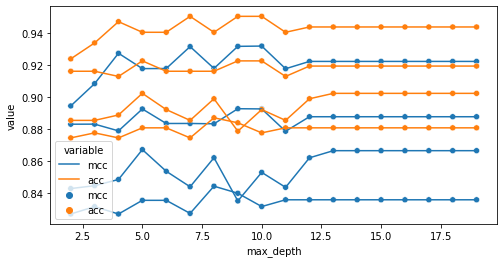

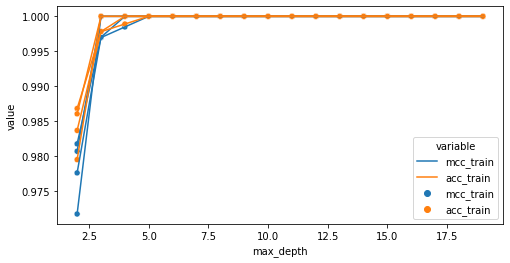

In [115]:
scores_all_folds

to_plot = scores_all_folds[['max_depth', 'fold', 'mcc', 'acc']].drop_duplicates()
to_plot = pd.melt(to_plot, ['max_depth', 'fold'])
to_plot
plt.figure(figsize=(8, 4))
sp = sb.scatterplot(data=to_plot, x = 'max_depth', y = 'value', hue='variable')
lp = sb.lineplot(data=to_plot, x = 'max_depth', y = 'value', hue='variable', units='fold', estimator=None)

plt.savefig('tree_depth_experiment/acc_and_mcc_scores_all_folds.svg')


# now plot train scores
to_plot = scores_all_folds[['max_depth', 'fold', 'mcc_train', 'acc_train']].drop_duplicates()
to_plot = pd.melt(to_plot, ['max_depth', 'fold'])
plt.figure(figsize=(8, 4))
sp = sb.scatterplot(data=to_plot, x = 'max_depth', y = 'value', hue='variable')
lp = sb.lineplot(data=to_plot, x = 'max_depth', y = 'value', hue='variable', units='fold', estimator=None)

plt.savefig('tree_depth_experiment/acc_and_mcc_train_scores_all_folds.svg')
    
